<center><img src="https://cdn.nlark.com/yuque/0/2021/png/1508544/1614177858441-c2f2df47-4316-4691-886a-1301e1a48c12.png"/></center>

- 在本节中，您将学习如何使用称为空间变换器网络的视觉注意机制来扩充您的网络。你可以在[DeepMind paper](https://arxiv.org/abs/1506.02025) 阅读更多有关空间变换器网络的内容。
- 空间变换器网络是对任何空间变换的差异化关注的概括。空间变换器网络（简称STN）允许神经网络学习如何在输入图像上执行空间变换， 以增强模型的几何不变性。例如，它可以裁剪感兴趣的区域，缩放并校正图像的方向。而这可能是一种有用的机制，因为CNN对于旋转和 缩放以及更一般的仿射变换并不是不变的。
- 关于STN的最棒的事情之一是能够简单地将其插入任何现有的CNN，而且只需很少的修改。

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # 交互模式

# 1. 加载数据
- 在这篇文章中，我们尝试了经典的 MNIST 数据集。使用标准卷积网络增强空间变换器网络。
- 代码加载数据会出现 httperror，建议使用cpu模式加载数据。
- 也可以直接按如下流程下载数据：
    - 代码成功从天池实验室点击编辑按钮加载到DSW，加载好的代码会⾃动打开，默认在<b>download</b>
⽬录下<br>
1、点击左侧的【天池】按钮<br>
2、会出现【保存到天池】按钮和【添加数据源】模块，搜索Pytorch_MNIST，点击数据集中的下载按钮即可<br>
###### （具体如下图所示）
<center><img
src="https://img.alicdn.com/imgextra/i4/O1CN01zsetgx1zaOBQbSDLs_!!6000000006730-2-
tps-616-589.png" width=60%></center>
核⼼问题2
数据集下载成功后，⻚⾯右上⻆会提示数据集下载成功，也会说名数据集存储位置，默认在
<b>download</b>⽬录下，如下图所示。
<center>
<img
src="https://img.alicdn.com/imgextra/i3/O1CN01uJzjgf1MLwg6jK7za_!!6000000001419-2-tps-
1409-377.png" width=60%>
<img
src="https://img.alicdn.com/imgextra/i1/O1CN01XQmAP027k1R811xls_!!6000000007834-2-
tps-857-465.png" width=60%>
</center>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练数据集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./Datasets', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# 测试数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./Datasets', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./Datasets\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./Datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./Datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./Datasets\MNIST\raw

Processing...
Done!


E:\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 2. 什么是空间变换器网络？
- 空间变换器网络归结为三个主要组成部分：
    - 本地网络（Localisation Network）是常规CNN，其对变换参数进行回归。不会从该数据集中明确地学习转换，而是网络自动学习增强 全局准确性的空间变换。
    - 网格生成器( Grid Genator)在输入图像中生成与输出图像中的每个像素相对应的坐标网格。
    - 采样器（Sampler）使用变换的参数并将其应用于输入图像。

<img src="https://cdn.nlark.com/yuque/0/2021/jpeg/1508544/1614177973793-bb795bac-76db-42fa-bce9-e33e7de7a07c.jpeg"/>

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # 空间变换器定位 - 网络
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # 3 * 2 affine矩阵的回归量
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # 使用身份转换初始化权重/偏差
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # 空间变换器网络转发功能
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # 执行一般的前进传递
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

# 3. 训练模型
- 训练模型 现在我们使用 SGD（随机梯度下降）算法来训练模型。网络正在以有监督的方式学习分类任务。同时，该模型以端到端的方式自动学习STN。

In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# 一种简单的测试程序，用于测量STN在MNIST上的性能。.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # 累加批量损失
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # 获取最大对数概率的索引
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

# 4. 可视化STN结果
- 现在，我们将检查我们学习的视觉注意机制的结果。
- 我们定义了一个小辅助函数，以便在训练时可视化变换。

E:\anaconda3\lib\site-packages\torch\nn\functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
E:\anaconda3\lib\site-packages\torch\nn\functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.351966
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.771859


E:\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2189, Accuracy: 9411/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.511569
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.415852

Test set: Average loss: 0.1343, Accuracy: 9590/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.228155
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.323655

Test set: Average loss: 0.0869, Accuracy: 9734/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.173326
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.166460

Test set: Average loss: 0.0838, Accuracy: 9746/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.259564
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.136799

Test set: Average loss: 0.0606, Accuracy: 9807/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.184250
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.074640

Test set: Average loss: 0.0625, Accuracy: 9793/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.224447
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.104537

Test set: Average loss: 0.0710, Accuracy: 9785/10000 (98%)

Tra

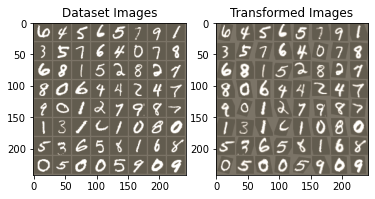

In [5]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# 我们想要在训练之后可视化空间变换器层的输出
# 我们使用STN可视化一批输入图像和相应的变换批次。
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# 在某些输入批处理上可视化STN转换
visualize_stn()

plt.ioff()
plt.show()

# 练习题
尝试在FashionMNIST上使用称为空间变换器网络的视觉注意机制来扩充网络。